Import libraries

In [0]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image

Load images

In [32]:
directory = '/content/drive/My Drive/NWPU-RESISC45/lake'
images = []
for file in tqdm(sorted(os.listdir(directory))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(directory + '/' + file)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    images.append(image)

images = np.array(images)

Load annotations

In [0]:
annotations = '/content/labels_satellite-lakes_20200428095149.json'

In [0]:
data = pd.read_json(annotations)

In [0]:
data = data.transpose().reset_index()[['filename', 'regions']]

In [223]:
data.head()

,filename,regions
0,lake_001.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
1,lake_002.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
2,lake_003.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
3,lake_004.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
4,lake_005.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."


In [224]:
data.shape

(91, 2)

Function to plot images with annotations

In [0]:
def plot_image(i):
  #Image
  filename = data.iloc[i][0]
  image_1 = Image.open(directory + '/' + filename).convert('RGBA')

  #Polygon
  image_2 = image_1.copy()

  for shape in range(len(data['regions'][i])):
    x = data['regions'][i][str(shape)]['shape_attributes']['all_points_x']
    y = data['regions'][i][str(shape)]['shape_attributes']['all_points_y']
    coordinates = list(zip(x,y))
    draw = ImageDraw.Draw(image_2)
    draw.polygon(coordinates, fill='white')

  #Merge images
  final_image = Image.blend(image_1, image_2, alpha=0.75)
  return final_image

Masks

In [0]:
def create_mask(i):
  #Image
  filename = data.iloc[i][0]
  image_1 = Image.open(directory + '/' + filename).convert('RGBA')

  #Polygon
  image_2 = image_1.copy()
  draw = ImageDraw.Draw(image_2)
  draw.rectangle([(0,0),image_1.size], fill='black')

  for shape in range(len(data['regions'][i])):
    x = data['regions'][i][str(shape)]['shape_attributes']['all_points_x']
    y = data['regions'][i][str(shape)]['shape_attributes']['all_points_y']
    coordinates = list(zip(x,y))
    draw.polygon(coordinates, fill='white')

  #Merge images
  final_image = Image.blend(image_1, image_2, alpha=1)
  return final_image

Sample Images

In [0]:
i = np.random.randint(0,len(data))

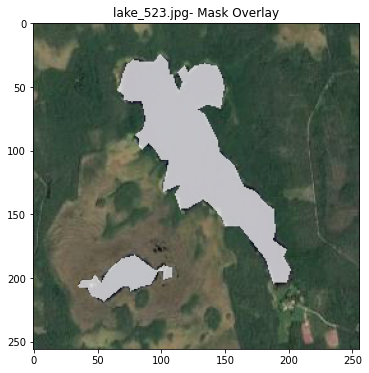

In [246]:
  plt.figure(figsize=(6,6))
  plt.imshow(plot_image(i))
  plt.title(filename + '- Mask Overlay')
  plt.show()

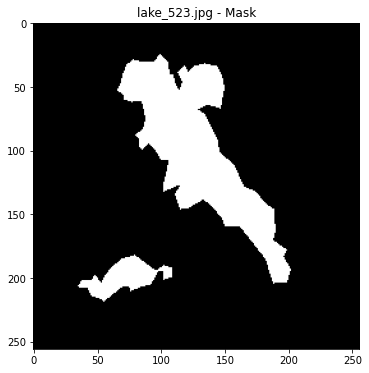

In [247]:
  plt.figure(figsize=(6,6))
  plt.imshow(create_mask(i))
  plt.title(filename + ' - Mask')
  plt.show()

Generate Masks

In [0]:
masks_directory = '/content/drive/My Drive/Lake - Masks'

In [251]:
for i in tqdm(range(0, len(data))):
  filename = data.iloc[i][0]
  image = create_mask(i)

  if image.mode in ("RGBA", "P"):
    image = image.convert("RGB")
  
  image.save(masks_directory + '/' + filename)

U-NET